Compare to P-Net:


|                         | accuracy | auc      | aupr     | f1       | precision | recall   |
|-------------------------|----------|----------|----------|----------|-----------|----------|
| P-net_ALL               | 0.838235 | 0.926789 | 0.878182 | 0.755556 | 0.750000  | 0.761194 |
| Logistic Regression_ALL | 0.833333 | 0.881904 | 0.808983 | 0.725806 | 0.789474  | 0.671642 |

In [1]:
import time
import tqdm

import numpy as np
import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, \
    f1_score, accuracy_score, precision_score, recall_score

from cancernet.arch import GATNet
from cancernet import PnetDataSet

## Load dataset

In [2]:
dataset = PnetDataSet(
    root="./data/prostate",
    name="prostate_graph_humanbase",
    #files={'graph_file': "global.geneSymbol.gz"},
    edge_tol=0.5,
    pre_transform=T.Compose([T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]))

Ensure consistent and reproducible train/validation/test split.

In [3]:
dataset.split_index_by_file(
    train_fp="./data/prostate/splits/training_set_0.csv",
    valid_fp="./data/prostate/splits/validation_set.csv",
    test_fp="./data/prostate/splits/test_set.csv"
)

In [4]:
dataset

PnetDataset(len=1011, graph=prostate_graph_humanbase, num_edges=15080, edge_tol=0.50)

Check whether test indices are fixed. 

Should be `[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]`

In [5]:
dataset.test_idx[0:10]

[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]

## Train

Set up hyperparameters, choose device, ...

In [6]:
batch_size = 10
parall = False
lr = 0.01

if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = "cpu"

print(device)

# keep everything reproducible!
torch.manual_seed(1)

cuda


Prepare data.

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=True,
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=True,
)

Create model.

In [8]:
model = GATNet(dims=[3, 64, 256, 128]).to(device)
#model = GCNNet(dims=[3, 64, 256, 128]).to(device)
#model = Net(dim=3).to(device)

Configure optimization.

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = F.nll_loss

Define training and validation functions for one epoch.

In [10]:
def train(
    epoch, model, optimizer, criterion, train_loader, parall=False, report=True, progbar=False
):
    model.train()

    # XXX learning rate scheduling shouldn't be hardcoded in here!
    if epoch == 30:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr * 0.5

    if epoch == 60:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr * 0.1
            
    total_loss = 0
    correct = 0
    num_samps = 0
    gen = tqdm.tqdm(train_loader) if progbar is True else train_loader
    device =next(iter(model.parameters())).device
    for data in gen:
        if not parall:
            data = data.to(device)
        optimizer.zero_grad()

        output = model(data)
        output = output.squeeze()

        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y

        if len(output.shape) == 1:
            output = output.unsqueeze(0)
        loss = criterion(output, y)

        pred = output.max(1)[1]
        correct += pred.eq(y).sum().item()
        total_loss += loss * len(data)
        loss.backward()
        optimizer.step()
        num_samps += len(y)

    avg_loss = total_loss / num_samps
    avg_acc = correct / num_samps

    if report:
        print(
            f"Epoch: {epoch:02}, Loss: {avg_loss:.3g}, Train Acc: {avg_acc:.4f}"
        )

    return avg_loss, avg_acc

In [11]:
def valid(model, criterion, valid_loader, parall=False):
    model.eval()

    correct = 0
    total_loss = 0
    num_samps = 0
    device =next(iter(model.parameters())).device
    for data in valid_loader:
        if not parall:
            data = data.to(device)
        output = model(data)
        output = output.squeeze()

        pred = output.max(1)[1]
        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y
        loss = criterion(output, y)
        total_loss += loss.item() * len(data)

        correct += pred.eq(y).sum().item()
        num_samps += len(y)
    return total_loss / num_samps, correct / num_samps

Run training.

In [12]:
train_losses = []
train_acces = []
valid_acces = []
valid_losses = []
t0 = time.time()
for epoch in tqdm.tqdm(range(1, 101)):
    report = (epoch) % 10 == 0

    train_loss, train_acc = train(
        epoch, model=model, optimizer=optimizer, criterion=criterion, train_loader=train_loader, parall=parall, report=report
    )
    valid_loss, valid_acc = valid(
        model=model, criterion=criterion, valid_loader=valid_loader, parall=parall
    )
    train_losses.append(train_loss.cpu().detach().numpy())
    valid_losses.append(valid_loss)
    train_acces.append(train_acc)
    valid_acces.append(valid_acc)
    if report:
        print("valid Loss: {:.3g}, Acc: {:.4f}".format(valid_loss, valid_acc))

print(f"Total training time: {time.time() - t0:.1f} seconds.")

 10%|█         | 10/100 [00:14<01:57,  1.31s/it]

Epoch: 10, Loss: 0.444, Train Acc: 0.7812
valid Loss: 0.428, Acc: 0.7400


 20%|██        | 20/100 [00:27<01:42,  1.28s/it]

Epoch: 20, Loss: 0.409, Train Acc: 0.8150
valid Loss: 0.427, Acc: 0.7900


 30%|███       | 30/100 [00:40<01:30,  1.29s/it]

Epoch: 30, Loss: 0.393, Train Acc: 0.8063
valid Loss: 0.417, Acc: 0.7800


 40%|████      | 40/100 [00:53<01:17,  1.29s/it]

Epoch: 40, Loss: 0.393, Train Acc: 0.8137
valid Loss: 0.393, Acc: 0.7900


 50%|█████     | 50/100 [01:05<01:04,  1.29s/it]

Epoch: 50, Loss: 0.391, Train Acc: 0.8225
valid Loss: 0.409, Acc: 0.7900


 60%|██████    | 60/100 [01:18<00:51,  1.29s/it]

Epoch: 60, Loss: 0.399, Train Acc: 0.8187
valid Loss: 0.382, Acc: 0.8100


 70%|███████   | 70/100 [01:31<00:38,  1.29s/it]

Epoch: 70, Loss: 0.393, Train Acc: 0.8200
valid Loss: 0.381, Acc: 0.8100


 80%|████████  | 80/100 [01:44<00:25,  1.29s/it]

Epoch: 80, Loss: 0.384, Train Acc: 0.8163
valid Loss: 0.398, Acc: 0.8000


 90%|█████████ | 90/100 [01:57<00:12,  1.29s/it]

Epoch: 90, Loss: 0.399, Train Acc: 0.8100
valid Loss: 0.396, Acc: 0.8100


100%|██████████| 100/100 [02:10<00:00,  1.31s/it]

Epoch: 100, Loss: 0.391, Train Acc: 0.8175
valid Loss: 0.391, Acc: 0.8000
Total training time: 130.6 seconds.


Visualize training trajectory.

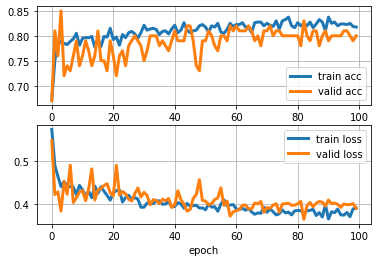

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(train_acces, label="train acc", linewidth=3)
ax1.plot(valid_acces, label="valid acc", linewidth=3)
ax1.legend()
ax1.set_xlabel("epoch")
ax1.grid()

ax2.plot(train_losses, c="tab:blue", label="train loss", linewidth=3)
ax2.plot(valid_losses, c="tab:orange", label="valid loss", linewidth=3)
ax2.legend()
ax2.set_xlabel("epoch")
ax2.grid()

Define helper function for calculating ROC curve and AUC.

In [14]:
def get_roc(model, loader, seed=1):
    # keep everything reproducible!
    torch.manual_seed(seed)

    outs = []
    ys = []
    device = next(iter(model.parameters())).device
    for tb in loader:
        tb = tb.to(device)
        outs.append(torch.exp(model(tb)).detach().cpu().clone().numpy())
        ys.append(tb.y.detach().cpu().clone().numpy())

    outs = np.concatenate(outs)
    ys = np.concatenate(ys)

    fpr, tpr, _ = roc_curve(ys, outs[:, 1])
    auc_value = auc(fpr, tpr)

    return fpr, tpr, auc_value, ys, outs

Calculate and show ROC and AUC.

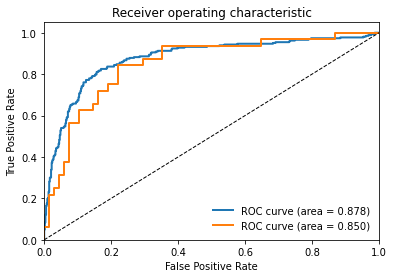

In [15]:
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader)
fpr_valid, tpr_valid, valid_auc, _, _ = get_roc(model, valid_loader)

fig, ax = plt.subplots()
ax.plot(
    fpr_train, tpr_train, lw=2, label="ROC curve (area = %0.3f)" % train_auc,
)
ax.plot(
    fpr_valid, tpr_valid, lw=2, label="ROC curve (area = %0.3f)" % valid_auc,
)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

Check performance on test set.

In [16]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=True,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader)

print('accuracy', accuracy_score(ys, outs[:, 1]>0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs[:, 1]))
print('f1', f1_score(ys, outs[:, 1]>0.5))
print('precision', precision_score(ys, outs[:, 1]>0.5))
print('recall', recall_score(ys, outs[:, 1]>0.5))

accuracy 0.86
auc 0.9203980099502487
aupr 0.8626685226756272
f1 0.7586206896551725
precision 0.88
recall 0.6666666666666666
